<a href="https://colab.research.google.com/github/harikuts/gesture_id/blob/master/Havarti_Gestures_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Using EMG data to classify different hand gestures.

http://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures# 


## Planning

### Current Project Goals
1. Decide on project organization structure
    - Google Drive vs Google Team Drive
    - Data Frames Structure
2. Import data using Pandas
    - Shown Below(Done?)
    - Split Up Data Frames for different gestures?
3. Parse and organize data into data objects
    - Try in Pandas first(Done?)
4. Train simple Logistic Regression model using Tensor Flow
5. Train a simple Neural Net model
6. Experiment with more complex models


Link to poster: https://1drv.ms/p/s!AiwOXLLwdF7SgbE0G3CX24pdBhg6Og 


## Resources

[Intro to Pandas](https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=pandas-colab&hl=en#scrollTo=rHLcriKWLRe4)

[Helpful Guide on Pandas Commands](https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/)

[First Steps with Tensor Flow](https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=firststeps-colab&hl=en#scrollTo=5M-Kt6w8U803)

[Train your first neural network: basic classification](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_classification.ipynb#scrollTo=jYysdyb-CaWM)

[ML Crash Course With Google using TensorFlow](https://developers.google.com/machine-learning/crash-course/)

[Basic Regression Model with Petrol Information](https://www.tensorflow.org/tutorials/keras/basic_regression)

[Pandas Statistic Functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html)

### Dealing With Time Series Data
[Time series and forecasting with Neural Networks](https://www.neuraldesigner.com/blog/time-series-and-forecasting-using-neural-networks)

[Time series feature extraction in python, for classification problems](https://stats.stackexchange.com/questions/199962/feature-extraction-for-time-series-classification)

### Feature Engineering
[Automated Feature Engineering in Python](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)

[Techniques for Feature Extraction from EMG Signal](https://www.researchgate.net/publication/51997893_Techniques_for_Feature_Extraction_from_EMG_Signal)

[Feature extraction and pattern recognition of EMG-based signal for hand movements](https://ieeexplore.ieee.org/document/7377314)

[Feature extraction and classification for EMG signals using linear discriminant analysis](https://ieeexplore.ieee.org/document/7748960)

[Bio-medical (EMG) Signal Analysis and Feature Extraction Using Wavelet Transform](http://www.ijera.com/papers/Vol5_issue3/Part%20-%201/E503011719.pdf)

### Model Building References
[Keras Examples](https://keras.io/getting-started/sequential-model-guide/)

# Setup

Run this code to mount the Google Team drive and set up the environment.

## Mount drives

Run this code to mount drives.

In [ ]:
# Call to mount Google Drive for Data Aquisition
# Only needs to be run once

from google.colab import drive

# # Grab google drive
drive.mount('/content/drive')

# !pip install -q seaborn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Git Check-in

*File -> Save a Copy in Github...*

# MAIN

##Load Data

In [ ]:
import os
import pdb
import pandas as pd
import threading
import time
import random
start_time = time.time()

START = 1
END = 35
# SLIDER = 12
NUM_TRAIN = 28 # MINIMUM 4
NUM_VALID = 3
# Find file path (may be unnecesary)
# !ls "/content/drive/Team Drives/Gestures Project/repo/"
# Specify file path
repopath = '/content/drive/Team Drives/Gestures Project/repo/'
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 ###
# repopath = "OneDrive/_School/Winter19/CMPS240/Gestures/repo/"

# Specify range of patients
THE_FORBIDDEN = [11, 30] # These are the 4 mandatory values as one of them has all possible classes.
ALL_PATIENTS = [i for i in range (START, END) if i not in THE_FORBIDDEN]
# PATIENTS = range(START, SLIDER)
# TEST_PATIENTS = range(SLIDER, END)
random.shuffle(ALL_PATIENTS) # For randomness.
SLIDER = NUM_TRAIN
SLIDER2 = NUM_TRAIN + NUM_VALID
PATIENTS = ALL_PATIENTS[:SLIDER]
VAL_PATIENTS = ALL_PATIENTS[SLIDER:SLIDER2]
TEST_PATIENTS = VAL_PATIENTS + ALL_PATIENTS[SLIDER2:]
print ("Training on", PATIENTS, "\nValidating on", VAL_PATIENTS, "\nTesting on", TEST_PATIENTS)

CHANNELS = ["channel" + str(x) for x in range(1,9)]
COLUMNS = CHANNELS[:].append("class")
CLASSNAMES = ["unmarked", "rest", "fist clench", "wrist flexion", "wrist extension", "radial deviation", "ulnar deviation", "extended palm"]

# Set patient dictionary
patientDict = {}

def load_data(patient,patientDict):
  # Create identifier tag
  identifier = "%02d" % (patient)
  # Create patient path and grab data files and store them in each patient entry
  patientDict[identifier] = []
  patientPath = repopath + identifier + "/"
  patientFiles = os.listdir(patientPath)
  for file in patientFiles:
    path = patientPath + file
    # Import data into pandas tables
    try:
      patientDict[identifier].append(pd.read_table(path))
#       print ("\tAdded data from", file, "!")
    except Exception as e:
      print ("Could not import data to patient", identifier, "from", patientPath, "\n", str(e))
  

threads = []
# STRUCTURE: patientDict[patient number][series number] -> pandas data file
# Grab data from patient
for patient in ALL_PATIENTS:
  print ("Processing patient", str(patient), "...")
  t = threading.Thread(target=load_data, args=(patient,patientDict,))
  threads.append(t)
  t.start()
  
for thread in threads:
  thread.join()
  
# FIND FULL CLASSES
def findFullClass(dataDict):
  fullPatients = []
  for i in range(1,32):
    identifier = "%02d" % (i)
    for data in patientDict[identifier]:
      copy = data.copy(deep=True)
      copy = copy.rename(columns={'class': 'classification'})
      cool = copy[copy.classification == 7]
#       print (identifier, ":", cool.shape)
#       fullPatients.append((identifier, cool.shape))
      if cool.shape[0] != 0 or copy.isnull():
        fullPatients.append(identifier)
  return fullPatients

# report = findFullClass(patientDict)
# print(report)
  
print ("Done!")
print("--- %s seconds ---" % (time.time() - start_time))

Training on [21, 28, 16, 33, 1, 15, 25, 20, 8, 27, 10, 22, 9, 4, 18, 7, 5, 6, 12, 32, 34, 19, 2, 29, 14, 26, 23, 31] 
Validating on [24, 13, 3] 
Testing on [24, 13, 3, 17]
Processing patient 21 ...
Processing patient 28 ...
Processing patient 16 ...
Processing patient 33 ...
Processing patient 1 ...
Processing patient 15 ...
Processing patient 25 ...
Processing patient 20 ...
Processing patient 8 ...
Processing patient 27 ...
Processing patient 10 ...
Processing patient 22 ...
Processing patient 9 ...
Processing patient 4 ...
Processing patient 18 ...
Processing patient 7 ...
Processing patient 5 ...
Processing patient 6 ...
Processing patient 12 ...
Processing patient 32 ...
Processing patient 34 ...
Processing patient 19 ...
Processing patient 2 ...
Processing patient 29 ...
Processing patient 14 ...
Processing patient 26 ...
Processing patient 23 ...
Processing patient 31 ...
Processing patient 24 ...
Processing patient 13 ...
Processing patient 3 ...
Processing patient 17 ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


Done!
--- 9.282251596450806 seconds ---


## Process Tools

### Statistical Features

In [ ]:
# Train Data Set
def extractStats(dataFrame):
  dataFrame = dataFrame.copy(deep=True)
  tempFrame = dataFrame.copy(deep=True)
  tempFrame = tempFrame.drop(["classification"], axis=1)
  
  dataFrame['std'] = tempFrame.std(axis = 1, skipna = True)
  dataFrame['mean'] = tempFrame.mean(axis = 1, skipna = True)
  dataFrame['max'] = tempFrame.max(axis = 1, skipna = True)
  dataFrame['median'] = tempFrame.median(axis = 1, skipna = True)
  dataFrame['min'] = tempFrame.min(axis = 1, skipna = True)
  dataFrame['var'] = tempFrame.var(axis = 1, skipna = True)
  return dataFrame

# dataFrame = extractStats(dataFrame)
# validDataFrame = extractStats(validDataFrame)
# testDataFrame = extractStats(testDataFrame)


print("Finished Adding Statistic Features")

Finished Adding Statistic Features


### Amplitude Refactoring

split up column into N subsets (via indices)

while not done:
grab all indices between (ts, te)
v = average of all positive peaks in the given indices

In [ ]:
import tensorflow as tf
from tensorflow import keras
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import time
import threading
import numpy as np
import operator
import pdb


# NEW
def rangeBuilder(lenData, segmentLen, span):
  # Set the number of steps based on the desired length of the segment
  numSteps = int(lenData / segmentLen)
  # Assemble tuples representing each segment neessary for processing
  ranges = []
  for i in range(numSteps):
    # Get the center and establish the range beginnings and ends
    center = i * segmentLen + int(segmentLen / 2)
    begin = max(0, int(center - span / 2))
    end = min(center + span / 2, lenData - 1)
    ranges.append((int(begin), int(end)))
  return ranges
  
def timeRefactor(timeData, ranges):
  refactoredTime = []
  for r in ranges:
    segment = timeData[r[0]:r[1]]
    newTime = sum(segment) / len(segment)
    refactoredTime.append(newTime)
  return refactoredTime
  
def ampRefactor(channelData, ranges): # span > lengthSegment results in interpolation (we want this!)
#   print ("ampRefactoring", channelData)
  # Process and create list of the peak averages in each range
  refactoredData = []
  for r in ranges:
#     print(r, r[0], r[1])
    segment = channelData[r[0]:r[1]]
    peakInds = find_peaks(segment)[0]
#     print(peakInds)
    peaks = [segment[ind] for ind in peakInds]
#     print("PEAK AT", peaks)
    if len(peaks) > 0:
      avgPeak = sum(peaks)/len(peaks)
      refactoredData.append(avgPeak)
    else:
      avgVal = sum(segment)/len(segment)
      refactoredData.append(avgVal)
#   print ("ampRefactored", refactoredData)
  return refactoredData

def labelRefactor(classData, ranges):
  # Similar to amplitude refactoring, but find the mode of each range
  refactoredClass = []
  for r in ranges:
    segment = classData[r[0]:r[1]]
#     mode = max(set(segment), key = segment.count)
    unique, counts = np.unique(segment, return_counts=True)
    mode = max(dict(zip(unique, counts)).items(), key=operator.itemgetter(1))[0]
    refactoredClass.append(mode)
  return refactoredClass

def reduceRefactorData(patientDictionary, segmentNum, span):
  reducedDict = {}
  reductionData = []
  for patient in ALL_PATIENTS:
    identifier = "%02d" % (patient)
#     print("Handling", identifier, "...")
    seriesList = []
    for data in patientDictionary[identifier]:
      startSize = data.shape[0]
      # Set up new patient dataframe
      patientData = pd.DataFrame(index=[], columns=[])
      # Copy data from original
      d = data.copy(deep=True)
#       print(d)
      segmentLen = len(d[CHANNELS[0]]) / segmentNum
      ranges = rangeBuilder(len(d[CHANNELS[0]]), segmentLen, span)
#       print(ranges)
      # Refactor time
      timeRefactor = labelRefactor(d["time"].values[:], ranges)
      patientData["time"] = timeRefactor
      # Refactor each channel and add to dataframe
      for channel in CHANNELS:
        singleChannelData = d[channel].values[:]
        refactoredChannelData = ampRefactor(singleChannelData, ranges)
        patientData[channel] = refactoredChannelData
#         print("Refactored", channel)
      # Refactor the class column and add to dataframe
      classRefactor = labelRefactor(d["class"].values[:], ranges)
      patientData["class"] = classRefactor
#       print("Refactored labels")
      seriesList.append(patientData)
      endSize = patientData.shape[0]
      reductionData.append((startSize, endSize))
    reducedDict[identifier] = seriesList
  return reducedDict, reductionData

def compileData(dataDict, patients, snippets=False, showPlot=False):
  dataFrames = []
  for patient in patients:
    identifier = "%02d" % (patient)
    for data in dataDict[identifier]:
      data = polish(data.copy(deep=True))
      data = shuffle(data)
      # Grabbing Shuffled data
      data = extractStats(data)
      if snippets:
        data = randomSnippets(data, 0.3)
      if showPlot==True:
        data.plot(subplots=True)
      dataFrames.append(data)
    
  return dataFrames

def randomSnippets(dataFrame, r):
  dataFrame = dataFrame.copy(deep=True)
  snapshotRatio = random.uniform(r, 1.0)
  numRows = dataFrame.shape[0]
  snapshotNum = int(snapshotRatio * numRows)
  startPoint = random.randint(0, numRows - snapshotNum)
  endPoint = startPoint + snapshotNum
  snap = dataFrame.iloc[startPoint:endPoint]
  # Grab Snippet
  return snap

def compileAllData(dataDict, patients):
  dataFrame = None
  for patient in patients:
    identifier = "%02d" % (patient)
    for data in dataDict[identifier]:
      if dataFrame is not None:
        dataFrame = pd.concat([dataFrame, data.copy(deep=True)])
      else:
        dataFrame = data.copy(deep=True)
  return dataFrame

def polish(dataFrame):
  # Data post-processing
  df = dataFrame.copy(deep=True)
  # Reassign to drop column
  df = df.rename(columns={'class': 'classification'})
  df = df.drop(["time"], axis=1)
  df = df.dropna()
  return df

def chop(dataFrame):
  dataFrame = dataFrame.copy(deep=True)
  chopped = []
  # Set tracker
  restingMidpoints = []
  tracking = True
  startPoint = 0
  endPoint = 0
  # Get classification column
  classCol = dataFrame['classification']
  for i in range(len(classCol)):
    if not tracking:
      if classCol[i] == 0:
        startPoint = i
        tracking = True
    if tracking:
      if classCol[i] != 0:
        endPoint = i
        tracking = False
        # Add that midpoint
        midPoint = (endPoint + startPoint) / 2
        restingMidpoints.append(int(midPoint))
  for i in range(len(restingMidpoints)-1):
    chopped.append(dataFrame.copy(deep=True).iloc[restingMidpoints[i]:restingMidpoints[i+1]])
  return chopped

def shuffle(dataFrame):
  chopped = chop(dataFrame)
  random.shuffle(chopped)
  shuffled = chopped[0]
  for piece in chopped[1:]:
#     print(type(shuffled))
    shuffled = pd.concat([shuffled, piece])
  shuffled = shuffled.reset_index(drop=True)
#   pdb.set_trace()
  return shuffled


from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def many2one(dfList):
  Xlist = []
  ylist = []
  for df in dfList:
    pieces = chop(df)
#     pieces = pieces[1:-1]
    for piece in pieces:
      # Get x values, easy peasy
      Xlist.append(piece.drop(columns="classification"))
      # Single y value is defined by the gesture that takes place in that snippet.
      # Grab unique values from y column, then sum (because rest is 0)
      ylist.append(sum(np.unique(piece["classification"])))
  X = normalizeData(Xlist)
  y = ylist
#   X = np.dstack(X)
#   y = np.dstack(y)
  return X, y

def normalizeData(dFrames):
  nFrames = []
  for i,df in enumerate(dFrames):
#     print(df.shape)
#     if i ==1:
#       df.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
    df=(df-df.min())/(df.max()-df.min())
  # Apply Feature extraction after normalization
#     df = extractStats(df)
#     if i ==1:
#       df.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
    nFrames.append(df)
  return nFrames

def getMinLen(dfLists):
  allLens = []
  for dfList in dfLists:
    for df in dfList:
      allLens.append(df.shape[0])
  standardLen = min(allLens)
  return standardLen

def trimDfList(dfList, trimLen):
  newDfList = []
  for df in dfList:
    df = df.copy(deep=True)
#     print(df.shape[0])
    start = int((df.shape[0] - trimLen) / 2)
    end = start + trimLen
    newDfList.append(df.iloc[start:end])
  return newDfList                    
#   for patient in ALL_PATIENTS:
#     identifier = "%02d" % (patient)
#     for data in patientDict[identifier]:
#       data = data.iloc[0:standardLen]

def pcaTransform(dfList, n_components):
  newDfList = []
  for df in dfList:
    df = df.copy(deep=True)
    pca = PCA(n_components=n_components)
    dfComp = pca.fit_transform(df)
    pcaDf = pd.DataFrame(data = dfComp, columns = [str(i) for i in range(1, 1+n_components)])
    pcaDf = pd.concat([df, pcaDf], axis=1, sort=False)
    print (df.shape, pcaDf.shape)
    newDfList.append(pcaDf)
  return newDfList

def plotPCA(trainDf, dataFrames_y):
  trainDf['target'] = dataFrames_y
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('1', fontsize = 15)
#   ax.set_ylabel('2', fontsize = 15)
#   ax.set_zlabel('3', fontsize = 15)
  ax.set_title('3 component PCA', fontsize = 20)
  targets = ['1', '2', '3', '4', '5', '6']
  colors = ['r', 'g', 'b', 'c', 'm', 'y']
  
  for target, color in zip(targets,colors):
    indicesToKeep = trainDf['target'] == int(target)
#     print(indicesToKeep)
    ax.scatter(trainDf.loc[indicesToKeep, '1']
#                , trainDf.loc[indicesToKeep, '2']
#                , trainDf.loc[indicesToKeep, '3']
               , c = color
               , s = 50)
  ax.legend(targets)
  ax.grid()
  
  # Remove Classificatrion
  trainDf = trainDf.drop(["target"], axis=1)
    
  

## Evaluation Tools

### Plotting Functions

In [ ]:
# def plotAccuracy(history):
#   # The history of our accuracy during training.
#   plt.plot(history.history['categorical_accuracy'])
#   plt.plot(history.history['val_categorical_accuracy'])
#   plt.title('Model Accuracy')
#   plt.ylabel('Accuracy')
#   plt.xlabel('Number of epochs')
#   plt.legend(['train', 'validation'], loc='upper left')
#   return plt

# def plotXEntropy(history):
#   # The history of our cross-entropy loss during training.
#   plt.plot(history.history['loss'])
#   plt.plot(history.history['val_loss'])
#   plt.title('Model Loss')
#   plt.ylabel('Loss')
#   plt.xlabel('Number of epochs')
#   plt.legend(['train', 'validation'], loc='upper right')
#   return plt

def plotAccuracy(histories):
  # Compile histories
  categorical_accuracy = []
  val_categorical_accuracy = []
  for history in histories:
    categorical_accuracy = categorical_accuracy + history.history['categorical_accuracy']
    val_categorical_accuracy = val_categorical_accuracy + history.history['val_categorical_accuracy']
  # The history of our accuracy during training.
  plt.plot(categorical_accuracy)
  plt.plot(val_categorical_accuracy)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Number of epochs')
  plt.legend(['train', 'validation'], loc='upper left')
  return plt

def plotXEntropy(history):
  # The history of our cross-entropy loss during training.
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Number of epochs')
  plt.legend(['train', 'validation'], loc='upper right')
  return plt

## Models

### Multilayer Perceptron (MLP)


In [ ]:
#***************************** Build Model 1************************************
from keras.metrics import categorical_accuracy
def createMLP():
  model = Sequential()
  model.add(Dense(1024, activation='sigmoid', input_dim=14))
#   model.add(Dropout(0.5))
  model.add(Dense(256, activation='sigmoid'))
#   model.add(Dropout(0.5))
  model.add(Dense(128, activation='sigmoid'))
  model.add(Dense(256, activation='sigmoid'))
  model.add(Dense(1024, activation='sigmoid'))
  model.add(Dense(2048, activation='sigmoid'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))

  sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.5, nesterov=True)
  model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=[categorical_accuracy])
  return model

Using TensorFlow backend.


###Neural Network  (NN)

In [ ]:
#***************************** Build Model 2************************************
def createNN():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=train_x.shape[1]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(7, activation='relu'))
  optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse', 'accuracy'])

  return model


###Gated Recurruent Unit (GRU)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD

def createGRU(n_timesteps, n_features, n_outputs):
  model = Sequential()
  model.add(GRU(512, activation='relu', input_shape=(n_timesteps, n_features)))
#   model.add(Dropout(0.625))
#   model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.5))
  model.add(Dense(n_outputs, activation='softmax'))
  
#   opti = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#   opti = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#   opti = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#   opti = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  opti = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
#   opti = SGD(lr=0.0001, decay=1e-6, momentum=0.5, nesterov=True)
  model.compile(loss='categorical_crossentropy',
                optimizer=opti,
                metrics=[categorical_accuracy])
  return model

### Simple RNN (SRNN)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN
from keras.metrics import categorical_accuracy

def createSRNN():
  RNN_Model = Sequential()
  RNN_Model.add(SimpleRNN(128, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'))
  RNN_Model.add(Dense(32, activation='sigmoid'))
  RNN_Model.add(Dense(7, activation='softmax'))
  # RNN_Model.add(LSTM(8))
  # RNN_Model.add(Dense(8, activation='sigmoid'))
  RNN_Model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=[categorical_accuracy])
  return RNN_Model
  

### Long Short-Term Memory (LSTM)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.metrics import categorical_accuracy

def createLSTM():
  GRU_Model = Sequential()
  GRU_Model.add(LSTM(128, activation='sigmoid', recurrent_activation='hard_sigmoid'))
  GRU_Model.add(Dense(32, activation='sigmoid'))
  GRU_Model.add(Dense(7, activation='softmax'))

  GRU_Model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=[categorical_accuracy])
  return GRU_Model


# train_x.as_matrix()
# train_xx = train_x.as_matrix()



# GRU_Model.fit(np.expand_dims(train_xx,-1), train_y, batch_size=1, epochs=3, class_weight=class_weights)
# GRU_Model.summary()

##Performance

### Pre-processing

In [ ]:
import time
start_time = time.time()


CHANNELS = ["channel" + str(x) for x in range(1,9)]
COLUMNS = CHANNELS[:].append("class")

# Amplitude Refactoring Data
print ("Translating patient data into localized amplitude...")

# standardize(patientDict)
processed, info = reduceRefactorData(patientDict, segmentNum=320, span=1000)

print("--- %s seconds ---" % (time.time() - start_time))

Translating patient data into localized amplitude...
--- 16.2593834400177 seconds ---


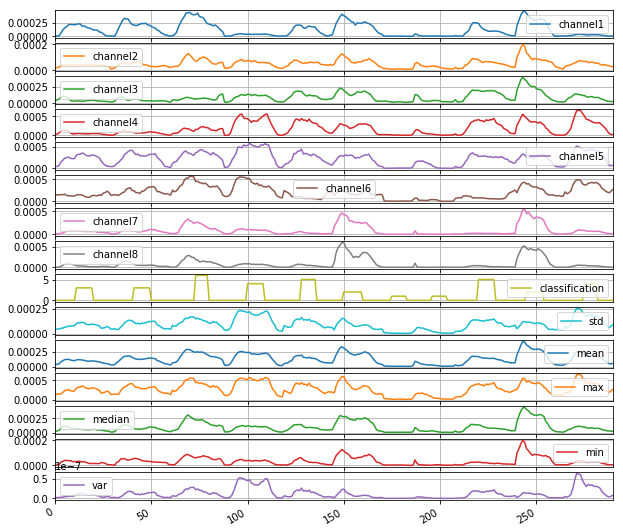

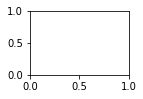

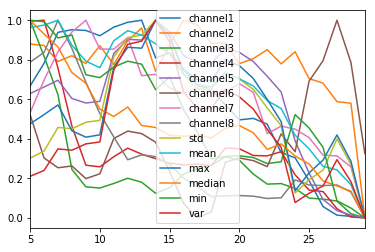

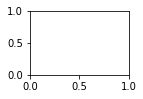

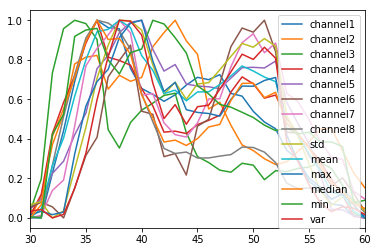

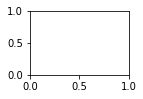

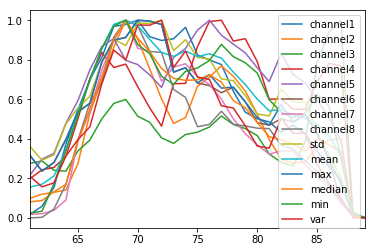

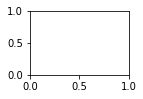

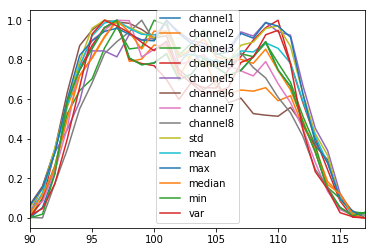

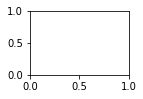

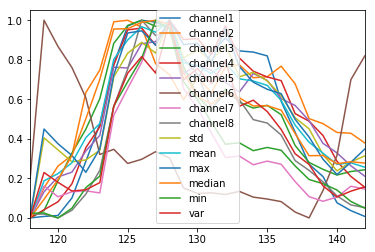

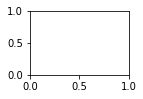

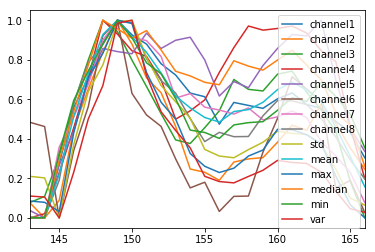

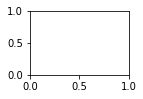

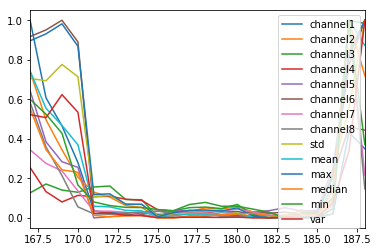

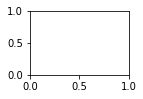

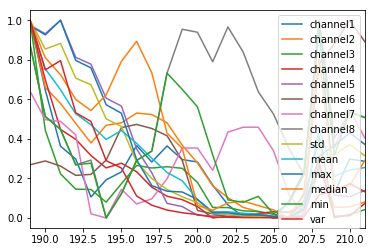

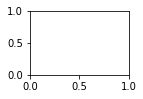

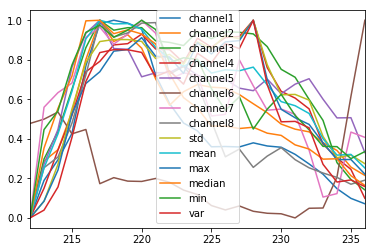

Standard length: 16
train: (560, 16, 14) (560, 7)
valid: (60, 16, 14) (60, 7)
test: (80, 16, 14) (80, 7)


In [ ]:
import keras
# print(info)

#### For Plotting Purposes######
# Raw Data
# rawData = polish(patientDict['01'][0])
# rawData.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
# plt.savefig('/content/drive/Team Drives/Gestures Project/plots/raw.png')

# # Just refactored
# checkit = polish(processed['01'][0])
# checkit.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
# plt.savefig('/content/drive/Team Drives/Gestures Project/plots/refactored.png')

# # Stat Feature Extraction
# statsbaby = extractStats(checkit)
# statsbaby.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
# plt.savefig('/content/drive/Team Drives/Gestures Project/plots/stat_extract.png')

# # Shuffled
# themshuffle = shuffle(checkit)
# themshuffle.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
# plt.savefig('/content/drive/Team Drives/Gestures Project/plots/themshuffle.png')

# # Random Snippets
# gotit = randomSnippets(themshuffle, 0.3)
# gotit.plot(subplots=True,legend=True,figsize=(10,10),grid=True);
# plt.savefig('/content/drive/Team Drives/Gestures Project/plots/snippets.png')
###########


# pdb.set_trace()
# dataFrame = compileAllData(processed, PATIENTS)
# validDataFrame = compileAllData(processed, VAL_PATIENTS)
# testDataFrame = compileAllData(processed, TEST_PATIENTS)
# dataFrame = polish(dataFrame)
# validDataFrame = polish(validDataFrame)
# testDataFrame = polish(testDataFrame)
dataFrames = compileData(processed, PATIENTS)
dataFrames[0].plot(subplots=True,legend=True,figsize=(10,10),grid=True)
plt.savefig('/content/drive/Team Drives/Gestures Project/plots/rawDataFrame.png')
plt.show()
dataFramesX, dataFramesY = many2one(dataFrames)
for i in range(9):
  plt.subplot(3, 3, i+1)
  dataFramesX[i].plot()
  plt.savefig('/content/drive/Team Drives/Gestures Project/plots/many2oneDf'+str(i)+'.png')
  plt.show()
# dataFramesX = normalizeData(dataFramesX)
# for df in dataFrames:
#   print(df)
# print(len(dataFrames))
# a = chop(dataFrames[0])
# print(a)
# a[0].plot()
# pdb.set_trace()
validDataFrames = compileData(processed, VAL_PATIENTS)
validDataFramesX, validDataFramesY = many2one(validDataFrames)
# validDataFrames = polish(validDataFrames)
# validDataFrames = extractStats(validDataFrames)
testDataFrames = compileData(processed, TEST_PATIENTS, snippets=False, showPlot=False)     
testDataFramesX, testDataFramesY = many2one(testDataFrames)

standardLen = getMinLen([dataFramesX, validDataFramesX, testDataFramesX])
print("Standard length:", standardLen)
dataFramesX = trimDfList(dataFramesX, standardLen)
validDataFramesX = trimDfList(validDataFramesX, standardLen)
testDataFramesX = trimDfList(testDataFramesX, standardLen)

# dataFramesX = pcaTransform(dataFramesX, 1)
# plotPCA(dataFramesX, dataFramesY)
dataFramesX = np.dstack(dataFramesX)
dataFramesX = np.transpose(dataFramesX, (2, 0, 1))
dataFramesY = pd.DataFrame(np.array(dataFramesY))
dataFramesY = keras.utils.to_categorical(dataFramesY)
print("train:", dataFramesX.shape, dataFramesY.shape)

# validDataFramesX = pcaTransform(validDataFramesX, 1)
validDataFramesX = np.dstack(validDataFramesX)
validDataFramesX = np.transpose(validDataFramesX, (2, 0, 1))
validDataFramesY = np.array(validDataFramesY)
validDataFramesY = keras.utils.to_categorical(validDataFramesY)
print("valid:", validDataFramesX.shape, validDataFramesY.shape)

# testDataFramesX = pcaTransform(testDataFramesX, 1)
testDataFramesX = np.dstack(testDataFramesX)
testDataFramesX = np.transpose(testDataFramesX, (2, 0, 1))
testDataFramesY = np.array(testDataFramesY)
testDataFramesY = keras.utils.to_categorical(testDataFramesY)
print("test:", testDataFramesX.shape, testDataFramesY.shape)

# import pdb
# pdb.set_trace()

# print(processed)
# print("WE'RE DONE!!!!")
# pdb.set_trace()
# processed['01'][0].plot
# for patient in PATIENTS:
#   identifier = "%02d" % (patient)
#   for i in range(2):
#     patientDict[identifier][i].plot(x='time', y=COLUMNS, subplots=True, title="patient%s" % (patient))
#     processed[identifier][i].plot(x='time', y=COLUMNS, subplots=True, title="patient%s" % (patient))




###Training

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 560 samples, validate on 60 samples
Epoch 1/50
560/560 [==============================] - 33s 59ms/step - loss: 8.1465 - categorical_accuracy: 0.2893 - val_loss: 1.4336 - val_categorical_accuracy: 0.3500
Epoch 2/50
560/560 [==============================] - 31s 55ms/step - loss: 7.0935 - categorical_accuracy: 0.3696 - val_loss: 1.3219 - val_categorical_accuracy: 0.3833
Epoch 3/50
560/560 [==============================] - 31s 55ms/step - loss: 7.0547 - categorical_accuracy: 0.3875 - val_loss: 1.3028 - val_categorical_accuracy: 0.5333
Epoch 4/50
560/560 [==============================] - 31s 56ms/step - loss: 6.8077 - categorical_accuracy: 0.3929 - val_loss: 1.3095 - val_categorical_accuracy: 0.3833
Epoch 5/50
560/560 [============================

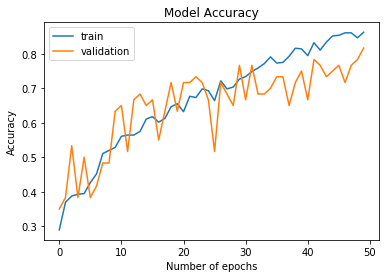

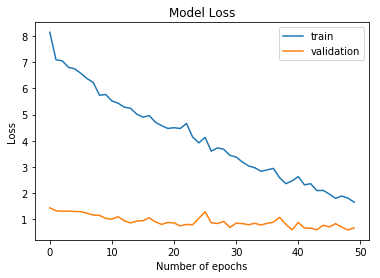

--- 1573.2176189422607 seconds ---


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD
import pdb
import random
import time

start_time = time.time()

# print(train_x.shape, type(train_x))

model3 = createGRU(dataFramesX.shape[1], dataFramesX.shape[2], dataFramesY.shape[1])
folder = 'SRNN'

histories = []
# Set class weight
class_weights = {0:1, 1:5, 2:5, 3:5, 4:5, 5:5, 6:5}

# # Now for each dataframe in training
# counter = 0
# total = len(dataFrames)
# print("Total train length:", total)
# for df in dataFrames:
#   counter=counter+1
#   print("Training on", counter, "of", total)
# #   print(df.shape) 
#   # Create train data
#   train = df
# #   print(train['classification'].unique())
#   train_y = keras.utils.to_categorical(train['classification'])
#   train_x = train.drop(columns="classification")
#   print(train_x.shape)
#   train_x.as_matrix()
# #   train_y = np.squeeze(train_y)
# #   train_x = np.squeeze(train_x)
  
#   # Create validation data
#   valid = validDataFrames[random.randint(0, len(validDataFrames)-1)]
# #   print(valid['classification'].unique())
#   valid_y = keras.utils.to_categorical(valid['classification'])
#   valid_x = valid.drop(columns="classification")
#   valid_x.as_matrix()
# #   valid_x = np.squeeze(valid_x)
# #   valid_y = np.squeeze(valid_y)
#   history = model3.fit(train_x,
#              train_y,
#              batch_size=1,
#              epochs=8,
#              class_weight=class_weights,
#              validation_data=(valid_x, valid_y)
#                       )
# #   pdb.set_trace()
#   model3.reset_states()
#   histories.append(history)
  
history = model3.fit(dataFramesX,
   dataFramesY,
   batch_size=1,
   epochs=50,
   class_weight=class_weights,
   validation_data=(validDataFramesX, validDataFramesY)
            )

model3.summary()
# pdb.set_trace()
accPlot = plotAccuracy([history])
accPlot.savefig('/content/drive/Team Drives/Gestures Project/plots/'+folder+'/accuracy.png')
accPlot.show()
xePlot = plotXEntropy(history)
xePlot.savefig('/content/drive/Team Drives/Gestures Project/plots/'+folder+'/loss.png')
xePlot.show()

print("--- %s seconds ---" % (time.time() - start_time))

###Testing

In [ ]:
# test_x.as_matrix()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

accuracies = []
# for i,df in enumerate(testDataFrames):
#   # Create test data
#   test = df
#   print(test['classification'].unique())
#   test_y = keras.utils.to_categorical(test['classification'])
#   test_x = test.drop(columns="classification")
#   test_x.as_matrix()
#   try:
LSTM_test_loss, LSTM_test_acc = model3.evaluate(testDataFramesX, testDataFramesY, batch_size=1)
#     LSTM_test_loss, LSTM_test_acc = model3.evaluate(np.expand_dims(test_x,-1), test_y, batch_size=1)
print("Score Model Accuracy: \n", LSTM_test_acc)
#     accuracies.append(LSTM_test_acc)
#     avgAcc = sum(accuracies) / len(accuracies)
#     print("Average Accuracy:", avgAcc)
#   except Exception as e:
#     print ("Unable to evaluate: \n\n", e)
#   predict_cat = model3.predict(testDataFramesX, batch_size=1)
#   prediction = [np.argmax(p) for p in predict_cat]
#   actual = [np.argmax(a) for a in test_y]
  
  # True accuracy processing (as we want to score actual gestures, not non-gestures, like rest)
  # Find indices of all real values where actual data shows rest
#   true_indices = [i for i in range(len(actual)) if actual[i] != 0]
#   accuracies.append(accuracy_score([actual[i] for i in true_indices], [prediction[i] for i in true_indices]))
#   avgAcc = sum(accuracies) / len(accuracies)
#   print("Average Accuracy:", avgAcc)
#   print (rest_indices)
#   pdb.set_trace()
#   plt.plot(actual, linestyle="-.")
#   plt.plot(prediction, linestyle=":")
#   plt.title('Prediction vs. Actual')
#   plt.ylabel('Classification')
#   plt.xlabel('Time Passing')
#   plt.legend(['actual', 'prediction'], loc='upper left')
#   plt.savefig('/content/drive/Team Drives/Gestures Project/plots/'+folder+'/testResults/'+str(i)+'testresult.png')
#   plt.show()
  


80/80 [==============================] - 0s 5ms/step
Score Model Accuracy: 
 0.725
